In [1]:
rootF = 'D:/Data/Paper defocus/Defocus detection data/'

In [2]:
import os as os
import csv 
from numpy import *
from scipy.stats import linregress, wilcoxon
import scipy.optimize

from matplotlib.pyplot import *
from matplotlib import gridspec
from matplotlib.gridspec import SubplotSpec
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.patches as pcs
from matplotlib.patches import Ellipse
import seaborn as sns

from shared.save_load import *
from shared.functions import convert_pvalue_to_stars

In [3]:
experiments = [20211129, 20211207, 20211208]
trials = [20, 37, 67]
run_nbs = [65, 58, 30]
N_cells = [21, 32, 29]

# Experiment conditions
from shared.parameters_stimulation2 import *
pixel_size_um = 3.5
pixel_per_check = 12
nb_checks = 60

defocuses = np.linspace(40, -40, 9)
mouse_dF_to_um_ratio = -5 #um
mouse_offset = defocuses * mouse_dF_to_um_ratio

# Load data

### Load responses to blurred images for the cells that were modelled with the CNN

from *CNN_predict.ipynb*

In [4]:
clusters_all_experiments = []

for iExp, exp in enumerate(experiments):
    print (exp)
    trial = trials[iExp]
    run_nb = run_nbs[iExp]
    n_cells = N_cells[iExp]
    print (n_cells, 'cells')
    data_path = rootF + '/Modelling/exp' + str(exp) + '/'
    data_CNN_cells = np.load(data_path + '{}_spike_counts_CNN_{}cells_tr{}_run{}.npz'.format(exp, n_cells, trial, run_nb))

    spike_counts_mean = data_CNN_cells['spike_count_mean'] * 1/0.3
    spike_counts_std = data_CNN_cells['spike_count_std'] * 1/0.3
    clusters = data_CNN_cells['clusters']
    clusters_all_experiments.append(clusters)

    print (clusters)

20211129
21 cells
[  1  96 140 141 200 234 293 314 347 390 396 401 406 416 417 424 437 508
 558 583 614]
20211207
32 cells
[ 52  89  95  98 107 129 148 179 186 217 303 359 378 381 386 388 393 394
 396 399 402 414 417 418 433 435 459 472 491 498 507 575]
20211208
29 cells
[ 20  56  62  83 130 138 168 238 263 280 285 368 380 382 411 419 424 435
 450 463 464 466 480 482 497 507 511 513 613]


### CNN predictions 1000 images

from *CNN_Convolve_and_predict.ipynb*

In [5]:
model_spike_counts_all_experiments = []

for iExp, exp in enumerate(experiments):
    print (exp)
    trial = trials[iExp]
    run_nb = run_nbs[iExp]
    n_cells = N_cells[iExp]
    model_predictions = load(rootF + "/Modelling/exp" + str(exp) + "/model_predictions_mouse_cnn_1000images_" + str(exp) + "_" + \
                                str(n_cells) + "cells_tr" + str(trial) + "_run" + str(run_nb) + ".npz")
    model_spike_counts = model_predictions['predictions'] * 1/0.3
    imagesNbs = model_predictions['images']
    print (model_spike_counts.shape)

    model_spike_counts_all_experiments.append(model_spike_counts)

20211129
(999, 2, 9, 4, 21)
20211207
(1000, 2, 9, 4, 32)
20211208
(999, 2, 9, 4, 29)


### Typing data

In [6]:
Folder = rootF + '/MEA/RGC typing/calcium comparison/'

euler_labels_f = open(Folder + 'Baden Types');
euler_labels_f = csv.reader(euler_labels_f,delimiter=",");
euler_labels={}
c=0
for row in euler_labels_f:
    if c==0:
        stim_cond_head = row
        c=1
    else:
        euler_labels[c-1]= row
        c+=1     
        
euler_label_names = []

for i in range(len(euler_labels)):
    euler_label_names.append(euler_labels[i][0])

In [7]:
# For each type, we store the corresponding cells per experiment 

euler_labels_cells_all_experiments = []
cells_clustering_all_experiments = []

for iLabel in range(len(euler_labels)):
    print (euler_labels[iLabel][0])
    euler_labels_cells = []
    
    for iExp, exp in enumerate(experiments):
        trial = trials[iExp]
        run_nb = run_nbs[iExp]
        n_cells = N_cells[iExp]
        exp_path = rootF + '/MEA/exp' + str(exp) + '/'

        # Load cells
        cells_clustering = load_obj(exp_path + str(exp) + '_selected_cells_clustering')
        cells_clustering = array(cells_clustering)
        if exp == 20211208:
            cell_types = load_obj(exp_path + str(exp) + '_celltype_Baden_cleaned_clus12_2024')
        else:
            cell_types = load_obj(exp_path + str(exp) + '_celltype_Baden_cleaned_2024')

        cell_type = euler_labels[iLabel][0]
        selected_cells = cells_clustering[cell_types == iLabel]
        print (exp, selected_cells)

        euler_labels_cells.append(selected_cells)

    euler_labels_cells_all_experiments.append(euler_labels_cells)

euler_labels_cells_all_experiments = np.array(euler_labels_cells_all_experiments, dtype='object')

OFF local OS
20211129 []
20211207 []
20211208 [ 86 136 276 292 318 389 438]
OFF DS
20211129 []
20211207 [ 63 120 298 583]
20211208 []
OFF step
20211129 [390]
20211207 []
20211208 []
OFF slow
20211129 [140 508 625]
20211207 [240 253 277 378]
20211208 [ 20 125 195]
OFF alpha sustained
20211129 [437 677]
20211207 [ 26 421]
20211208 []
ON-OFF JAM-B
20211129 [399 401]
20211207 [205 507]
20211208 [138 263 271 411 419 420 421 450 464 471 480]
OFF sustained
20211129 []
20211207 [394 414 433 459 471 515]
20211208 []
OFF alpha transient
20211129 [ 79 422]
20211207 []
20211208 [ 10 361]
OFF mini alpha transient
20211129 []
20211207 [148 303 398 426 506 538]
20211208 [210 382 387 441 466 497 576 580 605 613]
ON-OFF local-edge W3
20211129 [188 614]
20211207 [392]
20211208 [368]
ON-OFF local
20211129 []
20211207 [44]
20211208 [83]
ON-OFF DS 1
20211129 []
20211207 []
20211208 []
ON-OFF DS 2
20211129 []
20211207 []
20211208 [359 532 592]
ON-OFF local OS
20211129 [ 27 558 681]
20211207 [165]
20211208 [

### Explained variance

From code *CNN_Performance.ipynb*

In [8]:
explained_var_test = []
explained_var_blur = []

for iExp in range(len(experiments)):
    exp = experiments[iExp]
    trial = trials[iExp]
    run_nb = run_nbs[iExp]
    n_cells = N_cells[iExp]

    model_perf_test = np.load(rootF + '/Modelling/exp{}/CNN_trial{}_explained_variance_test.npz'.format(exp, trial, trial))
    explained_variance_test = model_perf_test['explained_variance']

    model_perf_blur = np.load(rootF + '/Modelling/exp{}/CNN_trial{}_explained_variance_blur.npz'.format(exp, trial, trial))
    explained_variance_blur = model_perf_blur['explained_variance']

    explained_var_test.append(explained_variance_test)
    explained_var_blur.append(explained_variance_blur)

### CNN predictions: example cell

From code *CNN_Predict.ipynb*

In [9]:
exp = 20211207
n_cells = 32#29
trial = 37#67
run_nb = 58#30

from shared.parameters_stimulation2 import *

In [10]:
data_path = rootF + '/Modelling/exp' + str(exp) + '/'
blur_data = np.load(data_path + '20211207_spike_counts_CNN_32cells_tr37_run58.npz')

spike_counts_mean_blur = blur_data['spike_count_mean']* 1/0.3
spike_counts_std_blur = blur_data['spike_count_std']* 1/0.3
clusters_blur = blur_data['clusters']

Ncells = len(clusters_blur)

print (np.shape(spike_counts_mean_blur))
print (clusters_blur)

(32, 4, 2, 9, 4)
[ 52  89  95  98 107 129 148 179 186 217 303 359 378 381 386 388 393 394
 396 399 402 414 417 418 433 435 459 472 491 498 507 575]


In [11]:
model_predictions_blur = np.load(rootF + "/Modelling/exp" + str(exp) + "/CNN_predictions_4_images_" + str(exp) + "_" + \
                             str(n_cells) + "cells_tr" + str(trial) + "_run" + str(run_nb) + ".npz")
model_spike_counts_blur = model_predictions_blur['predictions'] * 1/0.3

print (np.shape(model_spike_counts_blur))

(4, 2, 9, 4, 32)


In [12]:
# Cell's ellipse

ell_path = rootF + '/contrast analysis/ellipses_data_with_weights_2sigma_' + str(exp) 

ellipse_data_2s = load_obj(ell_path + '.pkl')

### Original images

In [13]:
path_to_original_images = rootF + '/Eye model simulations/original images/'
path_to_defocused_images = rootF + '/Eye model simulations/convolved images/20210219 Mouse/'
    
images = ['1','2','3','5']

# Figure

Example cell: 394
ON OFF local OS
130
OFF slow
140
ON alpha
463
ON-OFF local OS 3 cells
ON-OFF: 92.72605939272606 7.273940607273941
p= 0.0
TEST ON-OFF local, mean =  0.8117714120453913 STD =  0.13197191835357452
BLUR ON-OFF local, mean =  0.7747037879132687 STD =  0.29627337006810334
ON-OFF % neg delta 92.72605939272606
ON-OFF % pos delta 7.273940607273941
OFF slow 4 cells
OFF slow: 87.08708708708708 12.912912912912914
p= 0.0
TEST OFF, mean =  0.7620084891146346 STD =  0.13192624566439887
BLUR OFF, mean =  0.9150241435736579 STD =  0.06427826348139964
OFF slow % neg delta 87.08708708708708
OFF slow % pos delta 12.912912912912914
ON alpha 15 cells
ON alpha: 48.021354688021354 51.978645311978646
p= 0.999999841151946
TEST ON alpha, mean =  0.9626204527224863 STD =  0.01629368106925799
BLUR ON alpha, mean =  0.9740771902474469 STD =  0.02269389489452574
ON alpha % neg delta 48.021354688021354
ON alpha % pos delta 51.978645311978646


C:\Users\Sarah\AppData\Local\Temp\ipykernel_6848\3043430894.py:432: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  tight_layout()


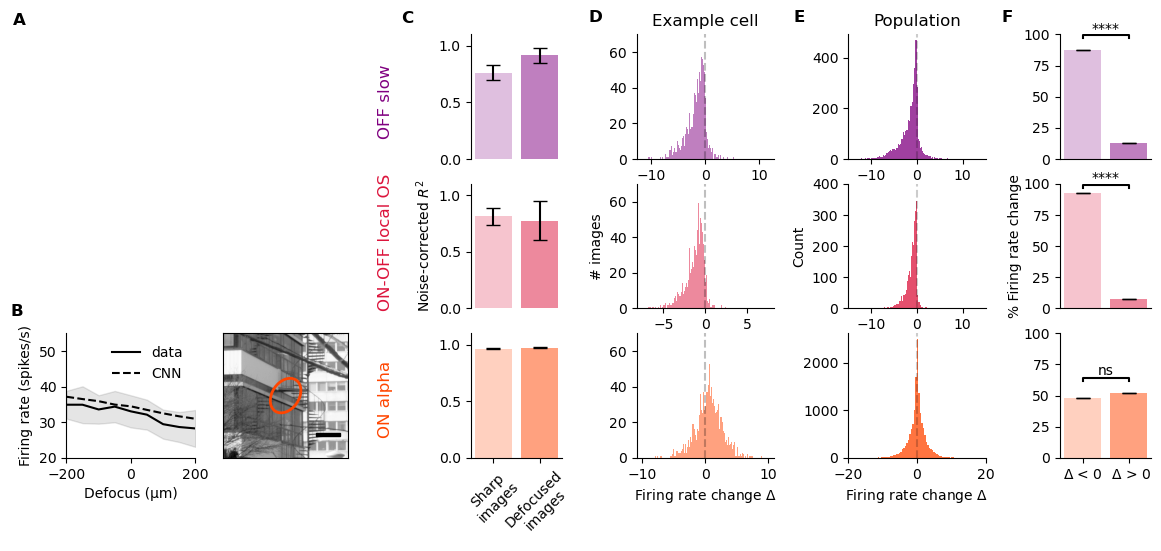

In [14]:
fig = figure(figsize=(14,5.5))
GS = fig.add_gridspec(1,2, width_ratios = [1.25,3], wspace = 0.25)

pup = 0

#################################### CNN ACCURACY: EXAMPLE CELL #################################### 

cols = ['C0','C1','C2','C3']
cell = 394 
idx = where(clusters_blur == cell)[0][0]
print ('Example cell:', cell)
ellipsepoints = ellipse_data_2s[cell]['ellipse_points']
x0, y0, width, height, angle = ellipse_data_2s[cell]['ellipse_parameters']

gs = gridspec.GridSpecFromSubplotSpec(3, 2, subplot_spec=GS[0])

# Only A label
ax = fig.add_subplot(gs[0,:])
ax.text(-0.19, 1.075, 'A', color='k', fontsize = 12, weight='bold')
ax.axis('off')

# Images
iImg = 0
img = imread(path_to_original_images + 'image_' + images[iImg] + '_image.png')

ax = fig.add_subplot(gs[2,1])
ax.imshow(img, cmap='Greys_r')
ellipse = pcs.Ellipse((x0,y0), width, height, angle=angle, fill=False, color='orangered',lw=2)
ax.add_artist(ellipse)
ax.set_yticks([])
ax.set_xticks([])
ax.set_xlim(x0-150,x0+150)
ax.set_ylim(y0+150,y0-150)
scalebar = AnchoredSizeBar(ax.transData, 57.14, '', 'lower right', pad=0.5, color='k',frameon=False, sep=0, \
                    size_vertical=5)
ax.add_artist(scalebar)

# RGC reponse
sc_max = max(amax(spike_counts_mean_blur[idx, :, pup, :, :]), amax(model_spike_counts_blur[:, pup, :, :, idx]))

iImg = 0
iEcc = 2
img = Imgs[iImg]
ax = fig.add_subplot(gs[2, 0])
ax.fill_between(mouse_offset, spike_counts_mean_blur[idx, iImg, pup, :, iEcc] - \
            spike_counts_std_blur[idx, iImg, pup, :, iEcc], \
            spike_counts_mean_blur[idx, iImg, pup, :, iEcc] + \
            spike_counts_std_blur[idx, iImg, pup, :, iEcc],
            color = 'k', alpha = 0.1)
ax.plot(mouse_offset, spike_counts_mean_blur[idx, iImg, pup, :, iEcc], color='k', label = 'data')
ax.plot(mouse_offset, model_spike_counts_blur[iImg, pup, :, iEcc, idx], '--', color='k', label='CNN')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim(20, 55)
ax.set_xlim(-200, 200)
ax.set_ylabel('Firing rate (spikes/s)')
ax.set_xlabel('Defocus (µm)')      
ax.legend(frameon=False)     
ax.text(-375, 60, 'B', color='k', fontsize = 12, weight='bold')

#################################### EXAMPLE CELLS #################################### 

gs = gridspec.GridSpecFromSubplotSpec(3, 4, subplot_spec=GS[1], wspace = 0.65, width_ratios = [1,1.5,1.5,1])

idx_ref = 0
src = 2

##### ON-OFF local OS slow, cluster 130
print ('ON OFF local OS')
iExp = 2
index = 4 
cell_nb = clusters_all_experiments[iExp][index]
print (cell_nb)

lim_min = amin(model_spike_counts_all_experiments[iExp][:, 0, -1, src, index] - model_spike_counts_all_experiments[iExp][:, 0, idx_ref, src, index])
lim_max = amax(model_spike_counts_all_experiments[iExp][:, 0, -1, src, index] - model_spike_counts_all_experiments[iExp][:, 0, idx_ref, src, index])
lim = 1.2*max(abs(lim_min), lim_max)

dAct_original = model_spike_counts_all_experiments[iExp][:, 0, -1, src, index] - model_spike_counts_all_experiments[iExp][:, 0, idx_ref, src, index]
ratio_neg_deltas = 100*len(where(dAct_original < 0)[0])/len(dAct_original)
ratio_pos_deltas = 100*len(where(dAct_original > 0)[0])/len(dAct_original)

ax = fig.add_subplot(gs[1,1])
ax.axvline(0, color='k',ls='--', alpha=0.25)
ax.hist(dAct_original, bins=100, alpha=0.5, histtype='stepfilled', color='crimson') #alpha=0.75, color = 'C0')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim(-lim, lim)
ax.set_ylim(0, 70)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('# images')
    
##### OFF slow, cluster 20
print ('OFF slow')
iExp = 0 
index = 2 
cell_nb = clusters_all_experiments[iExp][index]
print (cell_nb)

lim_min = amin(model_spike_counts_all_experiments[iExp][:, 0, -1, src, index] - model_spike_counts_all_experiments[iExp][:, 0, idx_ref, src, index])
lim_max = amax(model_spike_counts_all_experiments[iExp][:, 0, -1, src, index] - model_spike_counts_all_experiments[iExp][:, 0, idx_ref, src, index])
lim = 1.2*max(abs(lim_min), lim_max)

dAct_original = model_spike_counts_all_experiments[iExp][:, 0, -1, src, index] - model_spike_counts_all_experiments[iExp][:, 0, idx_ref, src, index]
ratio_neg_deltas = 100*len(where(dAct_original < 0)[0])/len(dAct_original)
ratio_pos_deltas = 100*len(where(dAct_original > 0)[0])/len(dAct_original)

ax = fig.add_subplot(gs[0,1])
ax.set_title('Example cell')
ax.axvline(0, color='k',ls='--', alpha=0.25)
ax.hist(dAct_original, bins=100, alpha=0.5, histtype='stepfilled', color='purple')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim(-lim, lim)
ax.set_ylim(0, 70)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.text(-1.7*lim, 70 + 0.1*70, 'D', color='k', fontsize = 12, weight='bold')

##### ON alpha, cluster 463
print ('ON alpha')
iExp = 2
index = 19 
cell_nb = clusters_all_experiments[iExp][index]
print (cell_nb)

lim_min = amin(model_spike_counts_all_experiments[iExp][:, 0, -1, src, index] - model_spike_counts_all_experiments[iExp][:, 0, idx_ref, src, index])
lim_max = amax(model_spike_counts_all_experiments[iExp][:, 0, -1, src, index] - model_spike_counts_all_experiments[iExp][:, 0, idx_ref, src, index])
lim = 1.2*max(abs(lim_min), lim_max)

dAct_original = model_spike_counts_all_experiments[iExp][:, 0, -1, src, index] - model_spike_counts_all_experiments[iExp][:, 0, idx_ref, src, index]
ratio_neg_deltas = 100*len(where(dAct_original < 0)[0])/len(dAct_original)
ratio_pos_deltas = 100*len(where(dAct_original > 0)[0])/len(dAct_original)

ax = fig.add_subplot(gs[2,1])
ax.axvline(0, color='k',ls='--', alpha=0.25)
ax.hist(dAct_original, bins=100, alpha=0.5, histtype='stepfilled', color='orangered')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim(-lim, lim)
ax.set_ylim(0, 70)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Firing rate change $\Delta$')

######################################## POPULATION ########################################

##### All ON-OFF local OS
iLabel = 13
cell_type = euler_labels[iLabel][0]
n_cells = len(where([euler_labels_cells_all_experiments[iLabel][0][i] == clusters_all_experiments[0] \
                     for i in range(len(euler_labels_cells_all_experiments[iLabel][0]))])[0]) \
            + len(where([euler_labels_cells_all_experiments[iLabel][1][i] == clusters_all_experiments[1] \
                     for i in range(len(euler_labels_cells_all_experiments[iLabel][1]))])[0]) \
            + len(where([euler_labels_cells_all_experiments[iLabel][2][i] == clusters_all_experiments[2] \
                     for i in range(len(euler_labels_cells_all_experiments[iLabel][2]))])[0])

print (cell_type, n_cells, 'cells')

n = 0
delta_sp_cnt_label = zeros((n_cells, 999))
explained_var_test_localOS = zeros(n_cells)
explained_var_blur_localOS = zeros(n_cells)
for iExp in range(len(experiments)):
    for iCell in range(len(euler_labels_cells_all_experiments[iLabel][iExp])):
        cell_nb = euler_labels_cells_all_experiments[iLabel][iExp][iCell]
        if cell_nb in clusters_all_experiments[iExp]:
            index = where(clusters_all_experiments[iExp] == cell_nb)[0][0]
            dAct_original = model_spike_counts_all_experiments[iExp][:, 0, -1, src, index] - \
                            model_spike_counts_all_experiments[iExp][:, 0, idx_ref, src, index]
            explained_var_test_localOS[n] = explained_var_test[iExp][index]
            explained_var_blur_localOS[n] = explained_var_blur[iExp][index]
            if experiments[iExp] == 20211207:
                delta_sp_cnt_label[n] = dAct_original[1:]
            else:
                delta_sp_cnt_label[n] = dAct_original
            n += 1

ratio_neg_deltas = 100*len(where(delta_sp_cnt_label.flatten() < 0)[0])\
                            /len(delta_sp_cnt_label.flatten())
ratio_pos_deltas = 100*len(where(delta_sp_cnt_label.flatten() > 0)[0])\
                            /len(delta_sp_cnt_label.flatten())
p_neg = ratio_neg_deltas/100
p_pos = ratio_pos_deltas/100
n_stats = len(delta_sp_cnt_label.flatten())
error_neg_ratios = (p_neg * (1-p_neg)/n_stats)*100
error_pos_ratios = (p_pos * (1-p_pos)/n_stats)*100
print ('ON-OFF:', ratio_neg_deltas, ratio_pos_deltas)

### Wilcoxon test
delta_SC = delta_sp_cnt_label.flatten()
samples_neg = delta_SC[delta_SC < 0]
samples_pos = delta_SC[delta_SC > 0]
test = wilcoxon(delta_SC[delta_SC != 0], alternative='less')
print ('p=', test[1])

### Explained variance
print ('TEST ON-OFF local, mean = ', mean(explained_var_test_localOS), 'STD = ', std(explained_var_test_localOS))
print ('BLUR ON-OFF local, mean = ', mean(explained_var_blur_localOS), 'STD = ', std(explained_var_blur_localOS))

ax = fig.add_subplot(gs[1,0])
ax.bar(x = 1, height = mean(explained_var_test_localOS), yerr = std(explained_var_test_localOS)/np.sqrt(len(explained_var_test_localOS)), \
                       ecolor='black', capsize=5, alpha=0.25, color='crimson')
ax.bar(x = 2, height = mean(explained_var_blur_localOS), yerr = std(explained_var_blur_localOS/np.sqrt(len(explained_var_test_localOS))), \
                       ecolor='black', capsize=5, alpha=0.5, color='crimson')
ax.set_ylabel('Noise-corrected $R^2$')
ax.text(-1.5, 0, 'ON-OFF local OS', rotation = 'vertical', color='crimson', fontsize = 12)
ax.set_ylim(0,1.1)
ax.set_xticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Histogram merged cells
ax = fig.add_subplot(gs[1,2])
ax.set_xlim(-15, 15)
ax.axvline(0, color='k',ls='--',alpha=0.2)
ax.hist(delta_sp_cnt_label.flatten(), bins=100, histtype='stepfilled', alpha=0.75, color = 'crimson')
ax.set_ylim(0, 400)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Count')

# Barplots
ax = fig.add_subplot(gs[1,3])
# p-values
x1, x2 = 1, 2
y, h, col = 97, 2, 'k'
ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
ax.text((x1+x2)*.5, y+h, str(convert_pvalue_to_stars(test[1])), ha='center', va='bottom', color=col)
# plot
ax.bar(x = 1, height = ratio_neg_deltas, yerr = error_neg_ratios, ecolor='black', capsize=5, alpha=0.25, color='crimson')
ax.bar(x = 2, height = ratio_pos_deltas, yerr = error_pos_ratios, ecolor='black', capsize=5, alpha=0.5, color='crimson')
ax.set_ylim(0, 100)
ax.set_ylabel('% Firing rate change', labelpad=1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([])
ax.set_xticklabels([])

print('ON-OFF % neg delta', ratio_neg_deltas)
print('ON-OFF % pos delta', ratio_pos_deltas)

##### All OFF slow cells
iLabel = 3
cell_type = euler_labels[iLabel][0]
n_cells = len(where([euler_labels_cells_all_experiments[iLabel][0][i] == clusters_all_experiments[0] \
                     for i in range(len(euler_labels_cells_all_experiments[iLabel][0]))])[0]) \
            + len(where([euler_labels_cells_all_experiments[iLabel][1][i] == clusters_all_experiments[1] \
                     for i in range(len(euler_labels_cells_all_experiments[iLabel][1]))])[0]) \
            + len(where([euler_labels_cells_all_experiments[iLabel][2][i] == clusters_all_experiments[2] \
                     for i in range(len(euler_labels_cells_all_experiments[iLabel][2]))])[0])

print (cell_type, n_cells, 'cells')

n = 0
delta_sp_cnt_label = zeros((n_cells, 999))
explained_var_test_OFFslow = zeros(n_cells)
explained_var_blur_OFFslow = zeros(n_cells)
for iExp in range(len(experiments)):
    for iCell in range(len(euler_labels_cells_all_experiments[iLabel][iExp])):
        cell_nb = euler_labels_cells_all_experiments[iLabel][iExp][iCell]
        if cell_nb in clusters_all_experiments[iExp]:
            index = where(clusters_all_experiments[iExp] == cell_nb)[0][0]
            dAct_original = model_spike_counts_all_experiments[iExp][:, 0, -1, src, index] - \
                            model_spike_counts_all_experiments[iExp][:, 0, idx_ref, src, index]
            explained_var_test_OFFslow[n] = explained_var_test[iExp][index]
            explained_var_blur_OFFslow[n] = explained_var_blur[iExp][index]
            if experiments[iExp] == 20211207:
                delta_sp_cnt_label[n] = dAct_original[1:]
            else:
                delta_sp_cnt_label[n] = dAct_original
            n += 1

ratio_neg_deltas = 100*len(where(delta_sp_cnt_label.flatten() < 0)[0])\
                            /len(delta_sp_cnt_label.flatten())
ratio_pos_deltas = 100*len(where(delta_sp_cnt_label.flatten() > 0)[0])\
                            /len(delta_sp_cnt_label.flatten())
p_neg = ratio_neg_deltas/100
p_pos = ratio_pos_deltas/100
n_stats = len(delta_sp_cnt_label.flatten())
error_neg_ratios = (p_neg * (1-p_neg)/n_stats)*100
error_pos_ratios = (p_pos * (1-p_pos)/n_stats)*100
print ('OFF slow:', ratio_neg_deltas, ratio_pos_deltas)

### Wilcoxon test
delta_SC = delta_sp_cnt_label.flatten()
samples_neg = delta_SC[delta_SC < 0]
samples_pos = delta_SC[delta_SC > 0]
test = wilcoxon(delta_SC[delta_SC != 0], alternative='less')
print ('p=', test[1])

### Explained variance
print ('TEST OFF, mean = ', mean(explained_var_test_OFFslow), 'STD = ', std(explained_var_test_OFFslow))
print ('BLUR OFF, mean = ', mean(explained_var_blur_OFFslow), 'STD = ', std(explained_var_blur_OFFslow))

ax = fig.add_subplot(gs[0,0])
ax.bar(x = 1, height = mean(explained_var_test_OFFslow), yerr = std(explained_var_test_OFFslow)/np.sqrt(len(explained_var_test_OFFslow)), \
                       ecolor='black', capsize=5, alpha=0.25, color='purple')
ax.bar(x = 2, height = mean(explained_var_blur_OFFslow), yerr = std(explained_var_blur_OFFslow), \
                       ecolor='black', capsize=5, alpha=0.5, color='purple')
ax.text(-1.5, 0.2, 'OFF slow', rotation = 'vertical', color='purple', fontsize = 12)
ax.set_ylim(0,1.1)
ax.set_xticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.text(-1, 1.2, 'C', color='k', fontsize = 12, weight='bold')

# Histogram merged cells
ax = fig.add_subplot(gs[0,2])
ax.axvline(0, color='k',ls='--',alpha=0.2)
ax.hist(delta_sp_cnt_label.flatten(), bins=100, histtype='stepfilled', alpha=0.75, color = 'purple')
ax.set_ylim(0, None)
ax.set_xlim(-15,15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Population')
ax.text(-27, 540, 'E', color='k', fontsize = 12, weight='bold')

# Barplots
ax = fig.add_subplot(gs[0,3])
# p-values
x1, x2 = 1, 2
y, h, col = max(ratio_neg_deltas, ratio_pos_deltas) + 10, 2, 'k'
ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
ax.text((x1+x2)*.5, y+h, str(convert_pvalue_to_stars(test[1])), ha='center', va='bottom', color=col)
# plot
ax.bar(x = 1, height = ratio_neg_deltas, yerr = error_neg_ratios, ecolor='black', capsize=5, alpha=0.25, color='purple')
ax.bar(x = 2, height = ratio_pos_deltas, yerr = error_neg_ratios, ecolor='black', capsize=5, alpha=0.5, color='purple')
ax.set_ylim(0, 100)
ax.set_xticks([])
ax.set_xticklabels([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.text(-0.75, 110, 'F', color='k', fontsize = 12, weight='bold')

print('OFF slow % neg delta', ratio_neg_deltas)
print('OFF slow % pos delta', ratio_pos_deltas)

##### All ON alpha cells (all experiments)
iLabel = 23
cell_type = euler_labels[iLabel][0]
n_cells = len(where([euler_labels_cells_all_experiments[iLabel][0][i] == clusters_all_experiments[0] \
                     for i in range(len(euler_labels_cells_all_experiments[iLabel][0]))])[0]) \
            + len(where([euler_labels_cells_all_experiments[iLabel][1][i] == clusters_all_experiments[1] \
                     for i in range(len(euler_labels_cells_all_experiments[iLabel][1]))])[0]) \
            + len(where([euler_labels_cells_all_experiments[iLabel][2][i] == clusters_all_experiments[2] \
                     for i in range(len(euler_labels_cells_all_experiments[iLabel][2]))])[0])

print (cell_type, n_cells, 'cells')

n = 0
delta_sp_cnt_label = zeros((n_cells, 999))
explained_var_test_ONalpha = zeros(n_cells)
explained_var_blur_ONalpha = zeros(n_cells)
for iExp in range(len(experiments)):
    for iCell in range(len(euler_labels_cells_all_experiments[iLabel][iExp])):
        cell_nb = euler_labels_cells_all_experiments[iLabel][iExp][iCell]
        if cell_nb in clusters_all_experiments[iExp]:
            index = where(clusters_all_experiments[iExp] == cell_nb)[0][0]
            dAct_original = model_spike_counts_all_experiments[iExp][:, 0, -1, src, index] - \
                            model_spike_counts_all_experiments[iExp][:, 0, idx_ref, src, index]
            explained_var_test_ONalpha[n] = explained_var_test[iExp][index]
            explained_var_blur_ONalpha[n] = explained_var_blur[iExp][index]
            if experiments[iExp] == 20211207:
                delta_sp_cnt_label[n] = dAct_original[1:]
            else:
                delta_sp_cnt_label[n] = dAct_original
            n += 1

ratio_neg_deltas = 100*len(where(delta_sp_cnt_label.flatten() < 0)[0])\
                            /len(delta_sp_cnt_label.flatten())
ratio_pos_deltas = 100*len(where(delta_sp_cnt_label.flatten() > 0)[0])\
                            /len(delta_sp_cnt_label.flatten())
p_neg = ratio_neg_deltas/100
p_pos = ratio_pos_deltas/100
n_stats = len(delta_sp_cnt_label.flatten())
error_neg_ratios = (p_neg * (1-p_neg)/n_stats)*100
error_pos_ratios = (p_pos * (1-p_pos)/n_stats)*100
print ('ON alpha:', ratio_neg_deltas, ratio_pos_deltas)

### Wilcoxon test
delta_SC = delta_sp_cnt_label.flatten()
samples_neg = delta_SC[delta_SC < 0]
samples_pos = delta_SC[delta_SC > 0]
test = wilcoxon(delta_SC[delta_SC != 0], alternative='less')
print ('p=', test[1])

### Explained variance
print ('TEST ON alpha, mean = ', mean(explained_var_test_ONalpha), 'STD = ', std(explained_var_test_ONalpha))
print ('BLUR ON alpha, mean = ', mean(explained_var_blur_ONalpha), 'STD = ', std(explained_var_blur_ONalpha))
ax = fig.add_subplot(gs[2,0])
ax.bar(x = 1, height = mean(explained_var_test_ONalpha), yerr = std(explained_var_test_ONalpha)/np.sqrt(len(explained_var_test_ONalpha)), \
                       ecolor='black', capsize=5, alpha=0.25, color='orangered')
ax.bar(x = 2, height = mean(explained_var_blur_ONalpha), yerr = std(explained_var_blur_ONalpha)/np.sqrt(len(explained_var_test_ONalpha)), \
                       ecolor='black', capsize=5, alpha=0.5, color='orangered')
ax.set_ylim(0,1.1)
ax.text(-1.5, 0.2, 'ON alpha', rotation = 'vertical', color='orangered', fontsize = 12)
ax.set_xticks([1, 2])
ax.set_xticklabels(['Sharp\nimages', 'Defocused\nimages'], rotation=45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Histogram merged cells
ax = fig.add_subplot(gs[2,2])
ax.axvline(0, color='k',ls='--',alpha=0.2)
ax.hist(delta_sp_cnt_label.flatten(), bins=100, histtype='stepfilled', alpha=0.75, color = 'orangered')
ax.set_ylim(0, None)
ax.set_xlim(-20, 20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Firing rate change $\Delta$')

# Barplots
ax = fig.add_subplot(gs[2, 3])
# p-values
x1, x2 = 1, 2
y, h, col = max(ratio_neg_deltas, ratio_pos_deltas) + 10, 2, 'k'
ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
ax.text((x1+x2)*.5, y+h, str(convert_pvalue_to_stars(test[1])), ha='center', va='bottom', color=col)
# plot
ax.bar(x = 1, height = ratio_neg_deltas, yerr = error_neg_ratios, ecolor='black', capsize=5, alpha=0.25, color='orangered')
ax.bar(x = 2, height = ratio_pos_deltas, yerr = error_neg_ratios, ecolor='black', capsize=5, alpha=0.5, color='orangered')
ax.set_ylim(0, 100)
ax.set_xticks([1, 2])
ax.set_xticklabels(['$\Delta$ < 0', ' $\Delta$ > 0'])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

tight_layout()

print('ON alpha % neg delta', ratio_neg_deltas)
print('ON alpha % pos delta', ratio_pos_deltas)

# ### Save figure
fig_path = 'T:/Documents/Papier defocus/figures/papier/'
fsave = fig_path + 'Fig3_raw'
# fig.savefig(fsave+'.pdf', format='pdf', dpi=300)
# fig.savefig(fsave+'.png', format='png', dpi=300, bbox_inches="tight")